In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device


device(type='cpu')

In [ ]:


df = pd.read_csv("/content/diabetes.csv").dropna().sample(frac=1)
print(len(df))
df.head(5)

768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
610,3,106,54,21,158,30.9,0.292,24,0
152,9,156,86,28,155,34.3,1.189,42,1
54,7,150,66,42,342,34.7,0.718,42,0
66,0,109,88,30,0,32.5,0.855,38,1
142,2,108,52,26,63,32.5,0.318,22,0


In [ ]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
class DiabetesDataset(Dataset):
    def __init__(self, split='Train'):
        # Initialize the dataset
        super(DiabetesDataset, self).__init__()

        # Read the diabetes dataset and shuffle the data
        df = pd.read_csv('/content/diabetes.csv').sample(frac=1)

        # Extract input features and normalize them
        self.df_x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                        'BMI', 'DiabetesPedigreeFunction', 'Age']]

        # Using .loc to avoid SettingWithCopyWarning
        self.df_x.loc[:, ["Glucose", "BloodPressure", "Insulin"]] /= 100  # normalization
        self.df_x.loc[:, ["BMI", "Age", "SkinThickness", "Pregnancies"]] /= 10  # normalization

        # Extract target variable
        self.df_y = df[['Outcome']]

        # Split the dataset based on the specified split
        if split == 'Train':
            # For training split, take the first 650 samples
            self.x = torch.from_numpy(self.df_x[:650].to_numpy()).type(torch.FloatTensor)
            self.y = torch.from_numpy(self.df_y[:650].to_numpy()).type(torch.LongTensor).squeeze(1)
            self.len = self.x.shape[0]
        elif split == 'Validation':
            # For validation split, take samples from index 650 to 709
            self.x = torch.from_numpy(self.df_x[650:710].to_numpy()).type(torch.FloatTensor)
            self.y = torch.from_numpy(self.df_y[650:710].to_numpy()).type(torch.LongTensor).squeeze(1)
            self.len = self.x.shape[0]
        elif split == 'Test':
            # For test split, take samples from index 710 to the end
            self.x = torch.from_numpy(self.df_x[710:].to_numpy()).type(torch.FloatTensor)
            self.y = torch.from_numpy(self.df_y[710:].to_numpy()).type(torch.LongTensor).squeeze(1)
            self.len = self.x.shape[0]

    def __getitem__(self, index):
        # Get an item from the dataset at the specified index
        return self.x[index], self.y[index]

    def __len__(self):
        # Return the length of the dataset
        return self.len


In [ ]:
train_data = DiabetesDataset(split = "Train")
valid_data = DiabetesDataset(split = "Validation")
test_data = DiabetesDataset(split = "Test")

train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = True)

<ipython-input-20-ea99ce89a30d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_x.loc[:, ["Glucose", "BloodPressure", "Insulin"]] /= 100  # normalization
<ipython-input-20-ea99ce89a30d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_x.loc[:, ["BMI", "Age", "SkinThickness", "Pregnancies"]] /= 10  # normalization
<ipython-input-20-ea99ce89a30d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [ ]:
y_check = []
for X,y in valid_data:
  y_check.append(y.item())

In [ ]:
np.array(y_check)

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [ ]:
import torch.nn as nn

class DiabetesNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DiabetesNet, self).__init__()

        # Dropout layer
        self.dropout = nn.Dropout(p=0.05)

        # Fully connected layers with ReLU activation
        self.input_layer = nn.Sequential(nn.Linear(input_size, 50), nn.ReLU())
        self.h1 = nn.Sequential(nn.Linear(50, 100), nn.ReLU())
        self.h2 = nn.Sequential(nn.Linear(100, 500), nn.ReLU())
        self.h3 = nn.Sequential(nn.Linear(500, 750), nn.ReLU())
        self.h4 = nn.Sequential(nn.Linear(750, 1000), nn.ReLU())
        self.h5 = nn.Sequential(nn.Linear(1000, 750), nn.ReLU())
        self.h6 = nn.Sequential(nn.Linear(750, 500), nn.ReLU())
        self.h7 = nn.Sequential(nn.Linear(500, 100), nn.ReLU())
        self.h8 = nn.Sequential(nn.Linear(100, 50), nn.ReLU())

        # Output layer with softmax activation
        self.h9 = nn.Sequential(nn.Linear(50, num_classes), nn.Softmax(dim=1))

    def forward(self,x):

      x = self.input_layer(x)
      x = self.h1(x)
      x = self.h2(x)
      x = self.h3(x)
      x = self.h4(x)
      x = self.h5(x)
      x = self.h6(x)
      x = self.h7(x)
      x = self.h8(x)
      x = self.h9(x)

      return x





creating model

In [ ]:
# Create an instance of the DiabetesNet model with input size 8 and output classes 2
model = DiabetesNet(8, 2)

# Set hyperparameters
learning_rate = 0.0001
epochs = 100

# Define the loss function (CrossEntropyLoss for classification tasks)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with weight decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.000001)

# Initialize min_loss to positive infinity, to be updated during training
min_loss = np.inf

# Lists to store training and validation losses, and validation accuracies during training
training_losses, valid_losses, accs = [], [], []

# Move the model to the specified device (GPU if available)
model.to(device)

# Comment: The model is now ready for training.


DiabetesNet(
  (dropout): Dropout(p=0.05, inplace=False)
  (input_layer): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
  )
  (h1): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
  )
  (h2): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU()
  )
  (h3): Sequential(
    (0): Linear(in_features=500, out_features=750, bias=True)
    (1): ReLU()
  )
  (h4): Sequential(
    (0): Linear(in_features=750, out_features=1000, bias=True)
    (1): ReLU()
  )
  (h5): Sequential(
    (0): Linear(in_features=1000, out_features=750, bias=True)
    (1): ReLU()
  )
  (h6): Sequential(
    (0): Linear(in_features=750, out_features=500, bias=True)
    (1): ReLU()
  )
  (h7): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=True)
    (1): ReLU()
  )
  (h8): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
  )
  (h9): Sequential(

In [ ]:
def train(min_loss):
    # Loop over the specified number of epochs
    for epoch in range(epochs):
        # Initialize training loss for the current epoch
        training_loss = 0

        # Set the model to training mode
        model.train()

        # Iterate through batches in the training loader
        for x, y in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Move data to the specified device (GPU, if available)
            x, y = x.to(device), y.to(device)

            # Forward pass
            yhat = model(x)

            # Compute the loss
            loss = criterion(yhat, y)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate the training loss for the current batch
            training_loss += loss.item()

        # Store the training loss for this epoch
        training_losses.append(training_loss)

        # Initialize validation loss and accuracy
        valid_loss = 0
        acc = 0

        # Set the model to evaluation mode (no gradient computation)
        model.eval()

        # Iterate through batches in the validation loader
        with torch.no_grad():
            for x, y in valid_loader:
                # Move data to the specified device (GPU, if available)
                x, y = x.to(device), y.to(device)

                # Forward pass
                yhat = model(x)

                # Compute the validation loss
                loss = criterion(yhat, y)
                valid_loss += loss.item()

                # Calculate accuracy
                _, top_class = yhat.topk(1, dim=1)#it returns top probability and indices
                eq = top_class == y.view(-1, 1)
                acc += eq.sum().item()

            # Store the validation loss and accuracy for this epoch
            valid_losses.append(valid_loss)
            accs.append((acc / len(valid_data)) * 100)

        # Print epoch statistics (training loss, validation loss, and accuracy)
        print("Epoch: {}.. \tTraining Loss: {:.5f}.. \tValid Loss: {:.5f}.. \tAccuracy: {:.2f}%..".format(epoch + 1, training_loss, valid_loss, (acc / len(valid_data)) * 100))

        # Check if the current validation loss is less than or equal to the minimum loss
        if valid_loss <= min_loss:
            # Save the model state, minimum loss, and learning rate to a file
            print("Saving Model {:.4f} ---> {:.4f}".format(min_loss, valid_loss))
            save_obj = OrderedDict([
                ("model", model.state_dict()),
                ("min_loss", min_loss),
                ("learning_rate", learning_rate)
            ])
            torch.save(save_obj, "diabetes2.pt")
            min_loss = valid_loss


In [ ]:
train(min_loss)

Epoch: 1.. 	Training Loss: 27.65030.. 	Valid Loss: 3.95830.. 	Accuracy: 66.67%..
Saving Model inf ---> 3.9583
Epoch: 2.. 	Training Loss: 27.20495.. 	Valid Loss: 3.84408.. 	Accuracy: 66.67%..
Saving Model 3.9583 ---> 3.8441
Epoch: 3.. 	Training Loss: 26.76485.. 	Valid Loss: 3.72672.. 	Accuracy: 66.67%..
Saving Model 3.8441 ---> 3.7267
Epoch: 4.. 	Training Loss: 25.64762.. 	Valid Loss: 3.47423.. 	Accuracy: 66.67%..
Saving Model 3.7267 ---> 3.4742
Epoch: 5.. 	Training Loss: 24.27717.. 	Valid Loss: 3.25320.. 	Accuracy: 66.67%..
Saving Model 3.4742 ---> 3.2532
Epoch: 6.. 	Training Loss: 24.43929.. 	Valid Loss: 3.24131.. 	Accuracy: 76.67%..
Saving Model 3.2532 ---> 3.2413
Epoch: 7.. 	Training Loss: 23.78496.. 	Valid Loss: 3.02451.. 	Accuracy: 81.67%..
Saving Model 3.2413 ---> 3.0245
Epoch: 8.. 	Training Loss: 23.44538.. 	Valid Loss: 2.93830.. 	Accuracy: 83.33%..
Saving Model 3.0245 ---> 2.9383
Epoch: 9.. 	Training Loss: 22.89117.. 	Valid Loss: 2.93560.. 	Accuracy: 83.33%..
Saving Model 2.938

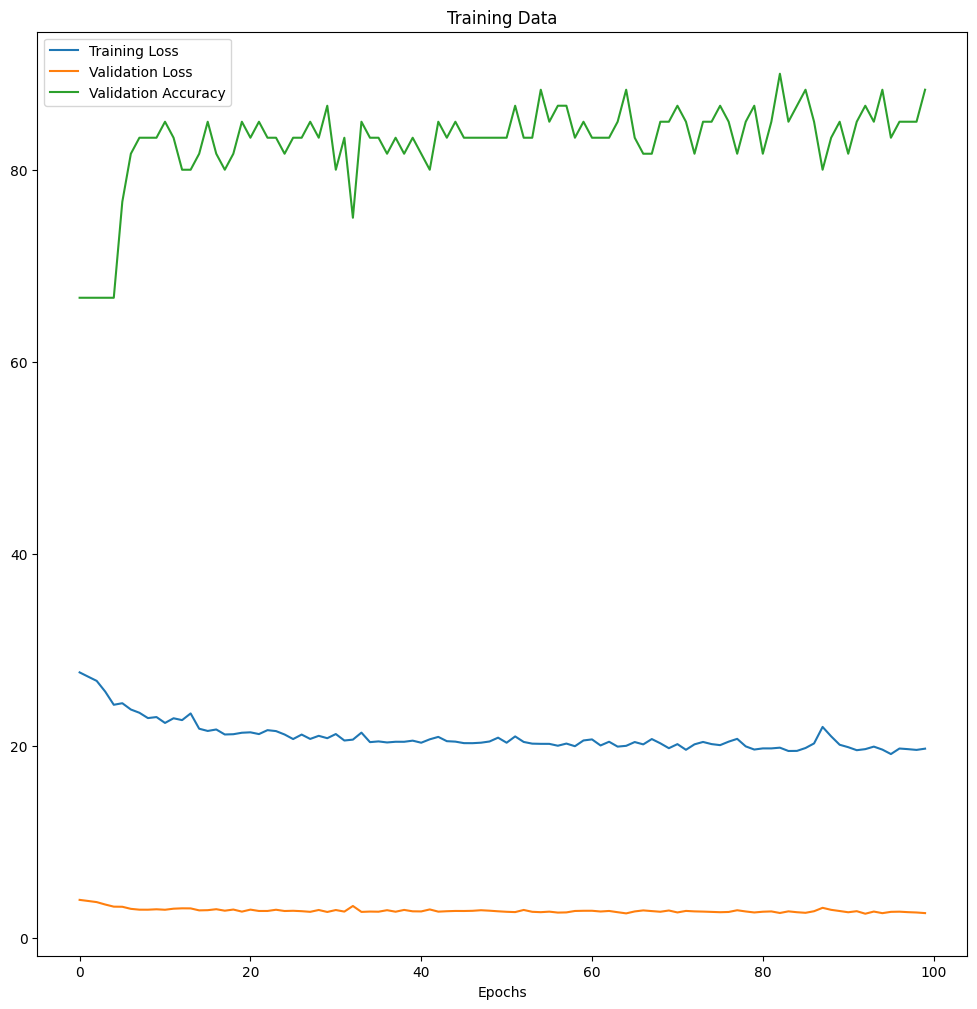

In [ ]:
%matplotlib inline

ephs = np.array([i for i in range(epochs)])

plt.figure(figsize = (12, 12))
plt.plot(ephs, np.array(training_losses), label = "Training Loss")
plt.plot(ephs, np.array(valid_losses), label = "Validation Loss")
plt.plot(ephs, np.array(accs), label = "Validation Accuracy")
plt.title("Training Data")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [ ]:
total_correct = 0

# Disable gradient computation for efficiency
with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()

    # Iterate through batches in the test loader
    for x, y in test_loader:
        # Move data to the specified device (GPU, if available)
        x, y = x.to(device), y.to(device)

        # Forward pass to obtain predictions
        yhat = model(x)

        # Get the predicted class and probability of the top prediction
        top_p, top_class = yhat.topk(1, dim=1)

        # Check if the predicted class matches the true class
        eq = top_class == y.view(-1, 1)

        # Update the total number of correct predictions
        total_correct += eq.sum().item()

        # Print information about the prediction
        print("Predicted Value: {}..\tConfidence: {:.4f}%..\tTrue Value: {}..".format(top_class.item(), top_p.item() * 100, y.item()))

# Print summary statistics
print("\n\nScore: {}/{}".format(total_correct, len(test_data)))
print("Percentage Correct: {:.2f}%".format((total_correct / len(test_data)) * 100))


Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 1..	Confidence: 98.6299%..	True Value: 1..
Predicted Value: 1..	Confidence: 80.1209%..	True Value: 1..
Predicted Value: 1..	Confidence: 84.7099%..	True Value: 1..
Predicted Value: 1..	Confidence: 82.7125%..	True Value: 1..
Predicted Value: 1..	Confidence: 70.2578%..	True Value: 1..
Predicted Value: 0..	Confidence: 99.8771%..	True Value: 0..
Predicted Value: 0..	Confidence: 99.9998%..	True Value: 0..
Predicted Value: 0..	Confidence: 99.6779%..	True Value: 0..
Predicted Value: 0..	Confidence: 99.2413%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 1..	Confidence: 99.4386%..	True Value: 1..
Predicted Value: 1..	Confidence: 99.9980%..	True Value: 0..
Predicted Value: 0..	Confidence: 50.4334%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 0..	Confidence: 100